# Differential Gene Expression in Inflammation Datasets

This reproduces the results from the two papers that analyzed these datasets:
- [Genomic responses in mouse models poorly mimic human inflammatory diseases](https://www.pnas.org/doi/10.1073/pnas.1222878110)
- [Genomic responses in mouse models greatly mimic human inflammatory diseases](https://pmc.ncbi.nlm.nih.gov/articles/PMC4313832)

### Setup

In [2]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [3]:
ANN_DATA_DIR = "data/anndata"
OUTPUT_DIR = "data/dge"

### Approach

The two papers used different approaches to extract significant genes. 

In [3]:
# load human burn data
human_burn = ad.read_h5ad(f"{ANN_DATA_DIR}/human_burn.h5ad")

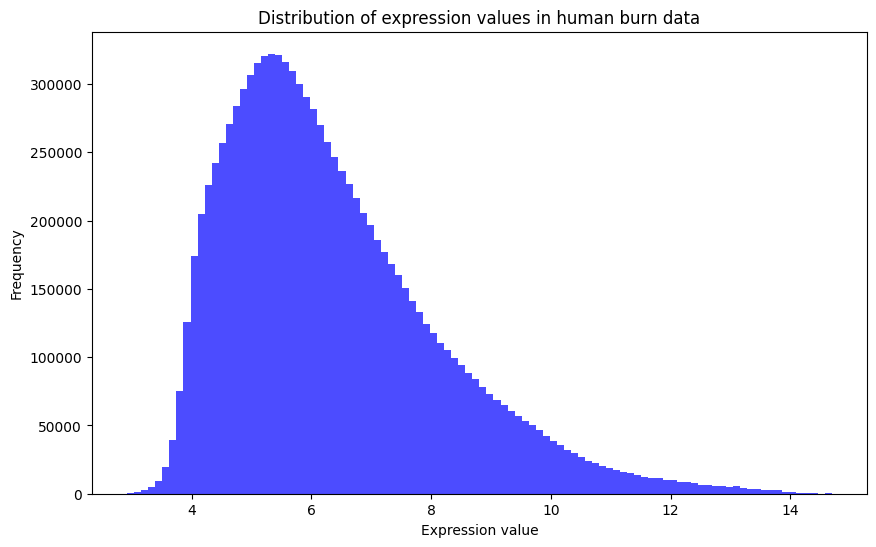

In [4]:
# check the distribution of expression values by plotting a histogram, X is a numpy array
plt.figure(figsize=(10, 6))

plt.hist(human_burn.X.flatten(), bins=100, color='blue', alpha=0.7)
plt.xlabel("Expression value")
plt.ylabel("Frequency")
plt.title("Distribution of expression values in human burn data")
plt.show()

since data is approximately gaussian, we can use t-tests with FDR correction + fold change threshold to identify significant genes

### Simple DGE pipeline

In [4]:
def compute_dge(
    adata,
    case_idx,
    ctrl_idx,
    fdr_method="fdr_bh",
    alpha=0.05,
    log2fc_thresh=1.0,
):
    """
    Compute differential gene expression (log2FC + Welch's t-test + FDR correction).

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix (samples x genes)
    case_idx : list-like
        Indices of case samples (relative to adata.obs)
    ctrl_idx : list-like
        Indices of control samples (relative to adata.obs)
    fdr_method : str
        Method for multiple testing correction (default: 'fdr_bh')
    alpha : float
        Significance threshold for adjusted p-values
    log2fc_thresh : float
        Minimum absolute log2 fold change to call significance
    """
    X = adata.X  # shape: (samples, genes)

    # Convert labels to integer positions
    case_pos = adata.obs.index.get_indexer(case_idx)
    ctrl_pos = adata.obs.index.get_indexer(ctrl_idx)

    # Slice arrays
    case_expr = X[case_pos, :]
    ctrl_expr = X[ctrl_pos, :]

    # log2 fold change (difference of means, since values already log-normalized)
    log2fc = case_expr.mean(axis=0) - ctrl_expr.mean(axis=0)

    # Welch's t-test for each gene
    _, pvals = stats.ttest_ind(case_expr, ctrl_expr, equal_var=False)

    # print nan pvals
    print(f"Number of NaN p-values: {np.sum(np.isnan(pvals))}")

    # convert Nans in pvals to 1.0 (not significant)
    pvals = np.nan_to_num(pvals, nan=1.0)

    # Multiple testing correction (FDR)
    p_adj = multipletests(pvals, method=fdr_method)[1]

    # Significance mask
    sig = (np.abs(log2fc) >= log2fc_thresh) & (p_adj < alpha)


    # assert none of the arrays contain NaNs
    assert not np.any(np.isnan(log2fc))
    assert not np.any(np.isnan(pvals))
    assert not np.any(np.isnan(p_adj))
    assert not np.any(pd.isnull(sig))

    # Save results into adata.var
    adata.var["log2FC"] = log2fc
    adata.var["pval"] = pvals
    adata.var["p_adj"] = p_adj
    adata.var["significant"] = sig

    return adata


### Human burn

Calculate dge between control baseline and inflammation samples

In [6]:
human_burn.obs

,group,tissue,sex,age,time_point
GSM909644,control,White Blood Cells,F,30,0.0
GSM909645,control,White Blood Cells,M,35,0.0
GSM909646,control,White Blood Cells,F,30,0.0
GSM909647,control,White Blood Cells,M,19,0.0
GSM909648,control,White Blood Cells,F,18,0.0
...,...,...,...,...,...
GSM910229,inflammation,White blood cells,M,8,42.0
GSM910230,inflammation,White blood cells,F,2,67.3
GSM910231,inflammation,White blood cells,M,0,73.1
GSM910232,inflammation,White blood cells,M,0,1204.5


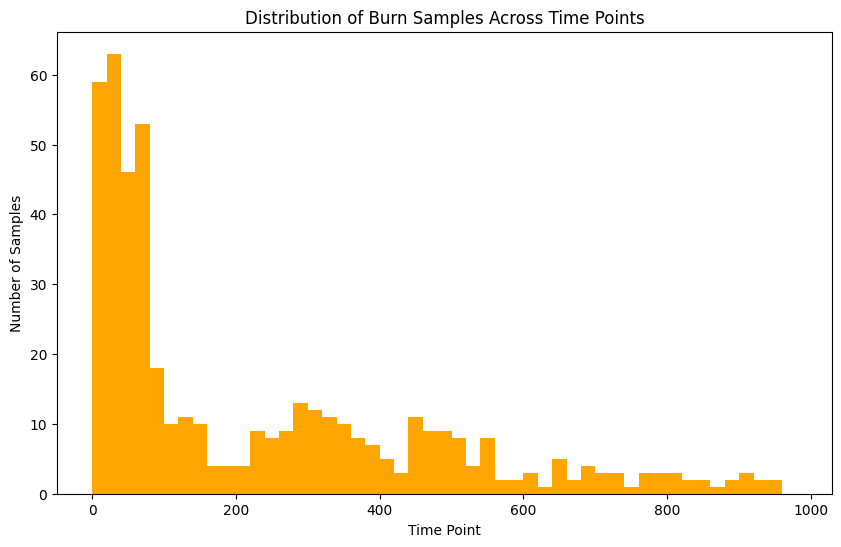

In [7]:
# plot the time_point column as a historgram of counts, binning by 10s, only showing inflammation group
plt.figure(figsize=(10, 6))

plt.hist(
    human_burn.obs[human_burn.obs["group"] == "inflammation"]["time_point"],
    bins=np.arange(0, 1000, 20),
    color="orange",
)
plt.xlabel("Time Point")
plt.ylabel("Number of Samples")
plt.title("Distribution of Burn Samples Across Time Points")
plt.show()


In [8]:
# find the min for inflammation group
min_time = human_burn.obs[human_burn.obs["group"] == "inflammation"]["time_point"].min()
# find the max for control group
max_time = human_burn.obs[human_burn.obs["group"] == "control"]["time_point"].max()

print(f"Min time point for inflammation group: {min_time}")
print(f"Max time point for control group: {max_time}")

Min time point for inflammation group: 1.7
Max time point for control group: 0.0


In [9]:
# calculate dge between control baseline and inflammation samples
control_baseline_idx = human_burn.obs.index[(human_burn.obs["group"] == "control")]
inflammation_idx = human_burn.obs.index[(human_burn.obs["group"] == "inflammation")]

human_burn_dge = compute_dge(
    human_burn,
    case_idx=inflammation_idx,
    ctrl_idx=control_baseline_idx,
    fdr_method="fdr_bh",
    alpha=0.05,
    log2fc_thresh=1.0,
)

Number of NaN p-values: 0


In [10]:
# check how many significant genes we have
significant_genes = human_burn_dge.var[human_burn_dge.var["significant"]]
print(f"Number of significant genes: {significant_genes.shape[0]}")

Number of significant genes: 955


In [11]:
# save new adata with dge results
human_burn_dge.write_h5ad(f"{OUTPUT_DIR}/human_burn_dge.h5ad")

### Human trauma

In [12]:
# load human trauma data
human_trauma = ad.read_h5ad(f"{ANN_DATA_DIR}/human_trauma.h5ad")

In [13]:
human_trauma.obs

,group,tissue,sex,age,time_point
GSM901358,control,White Blood Cells,M,27,0.0
GSM901359,control,White Blood Cells,F,41,0.0
GSM901360,control,White Blood Cells,F,18,0.0
GSM901361,control,White Blood Cells,F,51,0.0
GSM901362,control,White Blood Cells,M,26,0.0
...,...,...,...,...,...
GSM1639940,inflammation,White Blood Cells,F,43,32.8
GSM1639941,inflammation,White Blood Cells,F,43,107.3
GSM1639942,inflammation,White Blood Cells,F,43,176.9
GSM1639943,inflammation,White Blood Cells,F,46,33.7


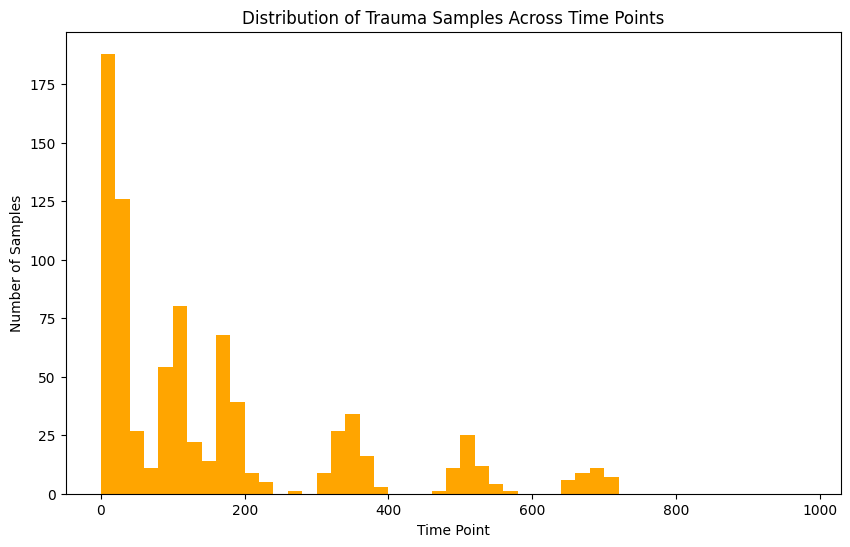

In [14]:
plt.figure(figsize=(10, 6))

plt.hist(
    human_trauma.obs[human_trauma.obs["group"] == "inflammation"]["time_point"],
    bins=np.arange(0, 1000, 20),
    color="orange",
)
plt.xlabel("Time Point")
plt.ylabel("Number of Samples")
plt.title("Distribution of Trauma Samples Across Time Points")
plt.show()


Second paper compared control baseline to 28 day trauma samples, we'll filter to those samples

In [15]:
# simple dge
control_baseline_idx = human_trauma.obs.index[(human_trauma.obs["group"] == "control")]
inflammation_idx = human_trauma.obs.index[
    (human_trauma.obs["group"] == "inflammation") & 
    (human_trauma.obs["time_point"] > 600)
]

human_trauma_dge = compute_dge(
    human_trauma,
    case_idx=inflammation_idx,
    ctrl_idx=control_baseline_idx,
    fdr_method="fdr_bh",
    alpha=0.05,
    log2fc_thresh=1.0,
)

Number of NaN p-values: 0


In [16]:
# count how many significant genes we have
significant_genes = human_trauma_dge.var[human_trauma_dge.var["significant"]]
print(f"Number of significant genes: {significant_genes.shape[0]}")

Number of significant genes: 1158


In [17]:
# save new adata with dge results
human_trauma_dge.write_h5ad(f"{OUTPUT_DIR}/human_trauma_dge.h5ad")

### Human sepsis

In [18]:
human_sepsis = ad.read_h5ad(f"{ANN_DATA_DIR}/human_sepsis.h5ad")
human_sepsis.obs

,tissue,group
GSM712478,whole blood,sepsis
GSM712479,whole blood,sepsis
GSM712480,whole blood,sepsis
GSM712481,whole blood,sepsis
GSM712482,whole blood,sepsis
GSM712483,whole blood,sepsis
GSM712484,whole blood,sepsis
GSM712485,whole blood,sepsis
GSM712486,whole blood,sepsis
GSM712487,whole blood,sepsis


In [19]:
# we'll compare sepsis vs healthy groups
sepsis_idx = human_sepsis.obs.index[human_sepsis.obs["group"] == "sepsis"]
healthy_idx = human_sepsis.obs.index[human_sepsis.obs["group"] == "healthy"]

# simple dge
human_sepsis_dge = compute_dge(
    human_sepsis,
    case_idx=sepsis_idx,
    ctrl_idx=healthy_idx,
    fdr_method="fdr_bh",
    alpha=0.05,
    log2fc_thresh=1.0,
)

Number of NaN p-values: 0


/home/amoneim/.pyenv/versions/geneformer/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [20]:
# count how many significant genes we have
significant_genes = human_sepsis_dge.var[human_sepsis_dge.var["significant"]]
print(f"Number of significant genes: {significant_genes.shape[0]}")

Number of significant genes: 784


In [21]:
# save the annadata with dge results
human_sepsis_dge.write_h5ad(f"{OUTPUT_DIR}/human_sepsis_dge.h5ad")

### Mouse burn

In [5]:
mouse_burn = ad.read_h5ad(f"{ANN_DATA_DIR}/mouse_burn.h5ad")
mouse_burn.obs

,title,study,group,time_point
GSM178608,Burn Blood 2 hr rep 1,Burn,inflammation,2.0
GSM178609,Burn Blood 2 hr rep 2,Burn,inflammation,2.0
GSM178610,Burn Blood 2 hr rep 3,Burn,inflammation,2.0
GSM178611,Burn Blood 2 hr rep 4,Burn,inflammation,2.0
GSM178612,Burn Blood 1 day rep 1,Burn,inflammation,24.0
GSM178613,Burn Blood 1 day rep 2,Burn,inflammation,24.0
GSM178614,Burn Blood 1 day rep 3,Burn,inflammation,24.0
GSM178615,Burn Blood 1 day rep 4,Burn,inflammation,24.0
GSM178616,Burn Blood 3 day rep 1,Burn,inflammation,72.0
GSM178617,Burn Blood 3 day rep 2,Burn,inflammation,72.0


The second paper compared control and burn samples at 168 hours, we'll filter to those samples

In [6]:
case_idx = mouse_burn.obs.index[
    (mouse_burn.obs["group"] == "inflammation") &
    (mouse_burn.obs["time_point"] == 168)
]
ctrl_idx = mouse_burn.obs.index[
    (mouse_burn.obs["group"] == "control") & 
    (mouse_burn.obs["time_point"] == 168)
]

print(case_idx, ctrl_idx)

# simple dge
mouse_burn_dge = compute_dge(
    mouse_burn,
    case_idx=case_idx,
    ctrl_idx=ctrl_idx,
    fdr_method="fdr_bh",
    alpha=0.05,
    log2fc_thresh=1,
)

Index(['GSM178620', 'GSM178621', 'GSM178622', 'GSM178623'], dtype='object') Index(['GSM178636', 'GSM178637', 'GSM178638', 'GSM178639'], dtype='object')
Number of NaN p-values: 0


/home/amoneim/.pyenv/versions/geneformer/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [7]:
# check how many significant genes we have
significant_genes = mouse_burn_dge.var[mouse_burn_dge.var["significant"]]
print(f"Number of significant genes: {significant_genes.shape[0]}")

Number of significant genes: 1308


In [8]:
# save andata with dge results
mouse_burn_dge.write_h5ad(f"{OUTPUT_DIR}/mouse_burn_dge.h5ad")

### Mouse trauma

In [9]:
mouse_trauma = ad.read_h5ad(f"{ANN_DATA_DIR}/mouse_trauma.h5ad")
mouse_trauma.obs

,title,study,group,time_point
GSM178704,Trauma Hemorrhage Spleen 2 hr rep 1,Trauma,inflammation,2.0
GSM178705,Trauma Hemorrhage Spleen 2 hr rep 2,Trauma,inflammation,2.0
GSM178706,Trauma Hemorrhage Spleen 2 hr rep 3,Trauma,inflammation,2.0
GSM178707,Trauma Hemorrhage Spleen 2 hr rep 4,Trauma,inflammation,2.0
GSM178708,Trauma Hemorrhage Spleen 1 day rep 1,Trauma,inflammation,24.0
GSM178709,Trauma Hemorrhage Spleen 1 day rep 2,Trauma,inflammation,24.0
GSM178710,Trauma Hemorrhage Spleen 1 day rep 3,Trauma,inflammation,24.0
GSM178711,Trauma Hemorrhage Spleen 1 day rep 4,Trauma,inflammation,24.0
GSM178712,Trauma Hemorrhage Spleen 3 day rep 1,Trauma,inflammation,72.0
GSM178713,Trauma Hemorrhage Spleen 3 day rep 2,Trauma,inflammation,72.0


second paper compared control and trauma samples at 3 days, we'll filter to those samples

In [10]:
case_idx = mouse_trauma.obs.index[
    (mouse_trauma.obs["group"] == "inflammation") &
    (mouse_trauma.obs["time_point"] == 168)
]
ctrl_idx = mouse_trauma.obs.index[
    (mouse_trauma.obs["group"] == "control") & 
    (mouse_trauma.obs["time_point"] == 168)
]

print(case_idx, ctrl_idx)

# simple dge
mouse_trauma_dge = compute_dge(
    mouse_trauma,
    case_idx=case_idx,
    ctrl_idx=ctrl_idx,
    fdr_method="fdr_bh",
    alpha=0.05,
    log2fc_thresh=1,
)

Index(['GSM178716', 'GSM178717', 'GSM178718', 'GSM178719'], dtype='object') Index(['GSM178732', 'GSM178733', 'GSM178734', 'GSM178735'], dtype='object')
Number of NaN p-values: 0


In [11]:
# check how many significant genes we have
significant_genes = mouse_trauma.var[mouse_trauma.var["significant"]]
print(f"Number of significant genes: {significant_genes.shape[0]}")

Number of significant genes: 666


In [12]:
# save andata with dge results
mouse_trauma_dge.write_h5ad(f"{OUTPUT_DIR}/mouse_trauma_dge.h5ad")

### Mouse sepsis

In [30]:
mouse_sepsis = ad.read_h5ad(f"{ANN_DATA_DIR}/mouse_sepsis.h5ad")
mouse_sepsis.obs

,strain,infection,time_point
GSM491049,A/J,none,0.0
GSM491050,A/J,Staphylococcus aureus,2.0
GSM491051,A/J,Staphylococcus aureus,4.0
GSM491052,A/J,Staphylococcus aureus,6.0
GSM491053,A/J,Staphylococcus aureus,12.0
GSM491054,C57BL/6J,none,0.0
GSM491055,C57BL/6J,Staphylococcus aureus,2.0
GSM491056,C57BL/6J,Staphylococcus aureus,4.0
GSM491057,C57BL/6J,Staphylococcus aureus,6.0
GSM491058,C57BL/6J,Staphylococcus aureus,12.0


Second paper used blood C57BL/6J samples at 4 hours post infection, vs. infection status none

In [31]:
case_idx = mouse_sepsis.obs.index[
    (mouse_sepsis.obs["strain"] == "C57BL/6J") &
    (mouse_sepsis.obs["infection"] == "Staphylococcus aureus") &
    (mouse_sepsis.obs["time_point"] == 4)
]
ctrl_idx = mouse_sepsis.obs.index[
    (mouse_sepsis.obs["strain"] == "C57BL/6J") &
    (mouse_sepsis.obs["infection"] == "none")
]

print(case_idx, ctrl_idx)

# simple dge
mouse_sepsis_dge = compute_dge(
    mouse_sepsis,
    case_idx=case_idx,
    ctrl_idx=ctrl_idx,
    fdr_method="fdr_bh",
    alpha=0.05,
    log2fc_thresh=1,
)

Index(['GSM491056', 'GSM491066', 'GSM491076', 'GSM491093', 'GSM491094'], dtype='object') Index(['GSM491054', 'GSM491064', 'GSM491074', 'GSM491089', 'GSM491090'], dtype='object')
Number of NaN p-values: 0


/home/amoneim/.pyenv/versions/geneformer/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [32]:
# find how many significant genes we have
significant_genes = mouse_sepsis.var[mouse_sepsis.var["significant"]]
print(f"Number of significant genes: {significant_genes.shape[0]}")

Number of significant genes: 530


In [33]:
# save anndata with dge results
mouse_sepsis_dge.write_h5ad(f"{OUTPUT_DIR}/mouse_sepsis_dge.h5ad")

### Mouse infection

In [34]:
mouse_infection = ad.read_h5ad(f"{ANN_DATA_DIR}/mouse_infection.h5ad")

In [35]:
mouse_infection.obs[mouse_infection.obs["time_point"] == 24]

,cohort,tissue,genotype,age,infection_status,time_point
GSM515522,C.albicans Initial Signature Cohort,Whole Blood,BALB/c,8 wk old,healthy,24.0
GSM515523,C.albicans Initial Signature Cohort,Whole Blood,BALB/c,8 wk old,healthy,24.0
GSM515524,C.albicans Initial Signature Cohort,Whole Blood,BALB/c,8 wk old,healthy,24.0
GSM515525,C.albicans Initial Signature Cohort,Whole Blood,BALB/c,8 wk old,healthy,24.0
GSM515527,C.albicans Initial Signature Cohort,Whole Blood,BALB/c,8 wk old,candida,24.0
GSM515528,C.albicans Initial Signature Cohort,Whole Blood,BALB/c,8 wk old,candida,24.0
GSM515529,C.albicans Initial Signature Cohort,Whole Blood,BALB/c,8 wk old,candida,24.0
GSM515530,C.albicans Initial Signature Cohort,Whole Blood,BALB/c,8 wk old,candida,24.0
GSM515531,C.albicans Initial Signature Cohort,Whole Blood,BALB/c,8 wk old,candida,24.0
GSM515532,C.albicans Initial Signature Cohort,Whole Blood,BALB/c,8 wk old,candida,24.0


we'll filter to BALB/c mice, 96 hours after infection, infection status as candida vs. healthy at 24 hours

In [36]:
case_idx = mouse_infection.obs.index[
    (mouse_infection.obs["genotype"] == "BALB/c") &
    (mouse_infection.obs["time_point"] == 96) &
    (mouse_infection.obs["infection_status"] == "candida")
]
ctrl_idx = mouse_infection.obs.index[
    (mouse_infection.obs["genotype"] == "BALB/c") &
    (mouse_infection.obs["time_point"] == 96) &
    (mouse_infection.obs["infection_status"] == "healthy")
]

print(case_idx, ctrl_idx)

# simple dge
mouse_infection_dge = compute_dge(
    mouse_infection,
    case_idx=case_idx,
    ctrl_idx=ctrl_idx,
    fdr_method="fdr_bh",
    alpha=0.05,
    log2fc_thresh=1,
)

Index(['GSM515535', 'GSM515549', 'GSM515550', 'GSM515551', 'GSM515552',
       'GSM515553', 'GSM515554'],
      dtype='object') Index(['GSM515526', 'GSM515559', 'GSM515560', 'GSM515561'], dtype='object')
Number of NaN p-values: 0


/home/amoneim/.pyenv/versions/geneformer/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [37]:
# find how many significant genes we have
significant_genes = mouse_infection.var[mouse_infection.var["significant"]]
print(f"Number of significant genes: {significant_genes.shape[0]}")

Number of significant genes: 509


In [38]:
# save annadata with dge results
mouse_infection_dge.write_h5ad(f"{OUTPUT_DIR}/mouse_infection_dge.h5ad")